# Excess Deaths in the United States

This notebook analyzes excess deaths in the US, using data form [NCHS Mortality Surveillance](https://gis.cdc.gov/grasp/fluview/mortality.html).  This data dump is particularly for flu, but it includes total deaths, which is the number we're looking for.

The goal is to reproduce the [Financial Times analysis](https://www.ft.com/content/6bd88b7d-3386-4543-b2e9-0d5c6fac846c) and look at states the FT doesn't directly cover.

## Setup

Load some useful Python modules:

In [1]:
%conda install -y seaborn

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [2]:
from pathlib import Path

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


Bad key "text.kerning_factor" on line 4 in
C:\Users\michaelekstrand\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## Load the Data

We'll start by loading in data from our CSV files:

In [4]:
raw_data = pd.concat([pd.read_csv(p, thousands=',') for p in Path('.').glob('*.csv')], ignore_index=True)
raw_data.head()

,AREA,SUB AREA,AGE GROUP,SEASON,WEEK,THRESHOLD,BASELINE,PERCENT P&I,NUM INFLUENZA DEATHS,NUM PNEUMONIA DEATHS,TOTAL DEATHS,PERCENT COMPLETE
0,National,NaN,All,2015-16,40,6.5,6.1,6.3,14,3197,50950,> 100%
1,National,NaN,All,2015-16,41,6.6,6.2,6.3,7,3131,49830,> 100%
2,National,NaN,All,2015-16,42,6.7,6.3,6.4,16,3214,50667,> 100%
3,National,NaN,All,2015-16,43,6.8,6.4,6.3,17,3163,50384,> 100%
4,National,NaN,All,2015-16,44,6.9,6.5,6.6,20,3353,51158,> 100%


Trim down to columns we care about:

In [5]:
deaths = pd.DataFrame({
    'Level': raw_data['AREA'].astype('category'),
    'Region': raw_data['SUB AREA'].fillna('USA').astype('category'),
    'Deaths': raw_data['TOTAL DEATHS']
})
deaths

,Level,Region,Deaths
0,National,USA,50950
1,National,USA,49830
2,National,USA,50667
3,National,USA,50384
4,National,USA,51158
...,...,...,...
1423,State,Washington,1266
1424,State,Washington,1271
1425,State,Washington,1211
1426,State,Washington,766


The flu season starts on week 40. So for the 2015-16 season, weeks 40-52 are 2015, and weeks 1-39 are 2016.  Let's make a Year 
column to deal with this better.

In [6]:
deaths['Year'] = raw_data['SEASON'].str.replace(r'-\d+$', '')
deaths['Week'] = raw_data['WEEK']
second_yr = deaths['Week'] < 40
deaths.loc[second_yr, 'Year'] = raw_data.loc[second_yr, 'SEASON'].str.replace(r'\d\d-', '')
deaths['Year'] = deaths['Year'].astype('i4')
deaths

,Level,Region,Deaths,Year,Week
0,National,USA,50950,2015,40
1,National,USA,49830,2015,41
2,National,USA,50667,2015,42
3,National,USA,50384,2015,43
4,National,USA,51158,2015,44
...,...,...,...,...,...
1423,State,Washington,1266,2020,13
1424,State,Washington,1271,2020,14
1425,State,Washington,1211,2020,15
1426,State,Washington,766,2020,16


2020 year 17 is unreliable, because it is too recent / incomplete. Remove it.

In [7]:
keep = deaths['Year'] < 2020
keep |= deaths['Week'] < deaths.iloc[-1, -1]
deaths = deaths[keep]

Index some useful deaths:

In [8]:
weekly = deaths.set_index(['Region', 'Year', 'Week'])['Deaths']
weekly.sort_index(inplace=True)
weekly.describe()

count     1422.000000
mean      9893.669480
std      19785.163531
min        219.000000
25%        581.000000
50%       1271.000000
75%       1949.750000
max      67495.000000
Name: Deaths, dtype: float64

Compute the *background* deaths - years 2016-2019:

In [9]:
bg_years = [2016, 2017, 2018, 2019]

In [10]:
background = deaths[(deaths['Year'] >= 2016) & (deaths['Year'] < 2020)]
background = background.groupby(['Region', 'Week'])['Deaths'].mean()
background.describe()

count      312.000000
mean      9862.815705
std      19756.733594
min        245.500000
25%        581.750000
50%       1286.500000
75%       1936.500000
max      60588.500000
Name: Deaths, dtype: float64

And we'll get the 2020 deaths:

In [11]:
current = deaths[deaths['Year'] == 2020].set_index(['Region', 'Week'])['Deaths']
current.describe()

count       96.000000
mean     10677.093750
std      21176.154978
min        245.000000
25%        629.000000
50%       1364.500000
75%       2181.000000
max      65524.000000
Name: Deaths, dtype: float64

## US Excess Deaths

Let's plot the current (2020) US deaths:

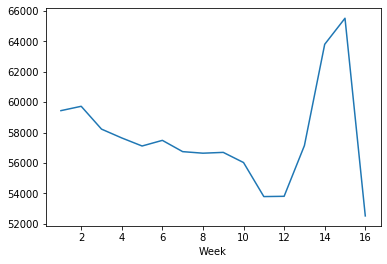

In [12]:
current.loc['USA'].plot()

Note that, even with the most recent week removed, there is still an unrealistic drop.  This is consistent with FT's reporting; not as severe as if we included week 17, but still a drop.  It's crucial to realize this drop is **not** a drop in deaths; it just means not all deaths from that week have been reported.

And average weekly deaths from previous years:

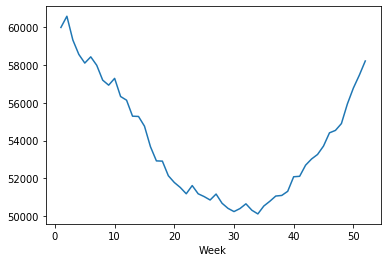

In [13]:
background.loc['USA'].plot()

And now, let's bring it together:

In [14]:
def ovl_deaths(region):
    bg = background.loc[region]
    cur = current.loc[region]
    plt.plot(bg.index, bg, label='Average')
    plt.plot(cur.index, cur, label='2020')
    plt.legend()

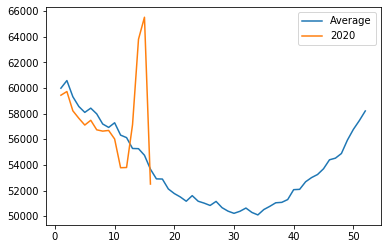

In [15]:
ovl_deaths('USA')

Can we get more detailed?  Let's fill each individual year, as a fainter color, with average and 2020 on top.

In [16]:
def ovl_deaths(region):
    bg = background.loc[region]
    cur = current.loc[region]
    
    for year in bg_years:
        old = weekly.loc[(region, year)]
        plt.plot(old.index, old, color='grey', alpha=0.3)
        
    plt.plot(bg.index, bg, label='Average')
    plt.plot(cur.index, cur, label='2020')
    plt.legend()

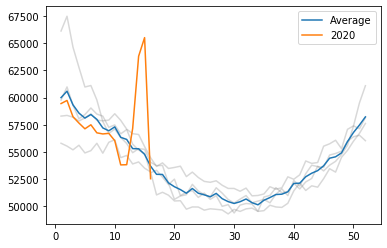

In [17]:
ovl_deaths('USA')

## Extra Deaths by State

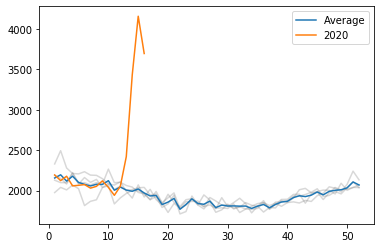

In [18]:
ovl_deaths('New York')

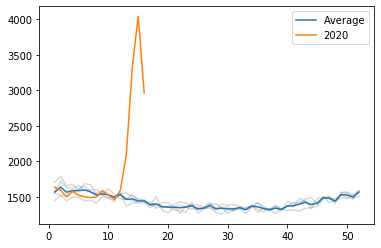

In [19]:
ovl_deaths('New Jersey')

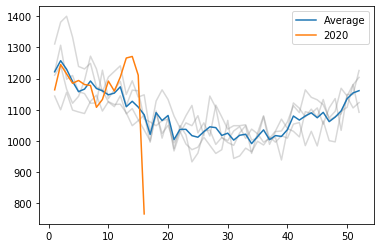

In [20]:
ovl_deaths('Washington')

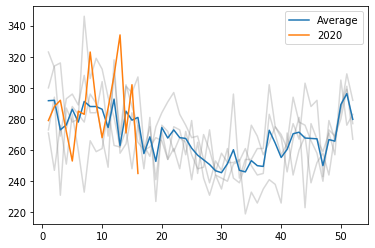

In [21]:
ovl_deaths('Idaho')

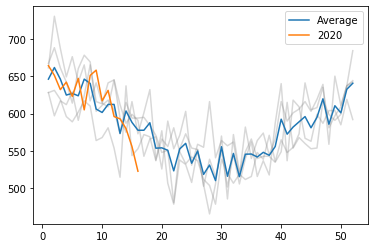

In [22]:
ovl_deaths('Iowa')